# Определение перспективного тарифа для телеком-компании

**Цель исследования** - определить, какой тарифный план компании «Мегалайн»: «Смарт» или «Ультра» приносит больше денег.

Необходимо проверить две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Ход исследования**

В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных. Также необходимо привести данные к нужным типам, найти и исправить ошибки. 

Исследование пройдет в четыре этапа:
- Обзор данных
- Предобработка данных
- Анализ данных
- Проверка гипотез

## Обзор данных

Импортируем необходимые библиотеки и сохраняем исходные файлы в переменных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [2]:
try:
    users = pd.read_csv(r'C:\Users\м\Documents\Data\users.csv')
except:
    users = pd.read_csv('/datasets/users.csv')
    
try:
    calls = pd.read_csv(r'C:\Users\м\Documents\Data\calls.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')

try:
    messages = pd.read_csv(r'C:\Users\м\Documents\Data\messages.csv')
except:
    messages = pd.read_csv('/datasets/messages.csv')
    
try:
    internet = pd.read_csv(r'C:\Users\м\Documents\Data\internet.csv')
except:
    internet = pd.read_csv('/datasets/internet.csv')
    
try:
    tariffs = pd.read_csv(r'C:\Users\м\Documents\Data\tariffs.csv')
except:
    tariffs = pd.read_csv('/datasets/tariffs.csv')

Посмотрим на первые строки таблиц.

In [3]:
display(users.head())
display(calls.head())
display(messages.head())
display(internet.head())
display(tariffs.head())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Согласно документации к данным:

Таблица `users` (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

Таблица `calls` (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Предобработка данных

### Исправление ошибок

Взглянем на информацию о данных.

In [4]:
display(users.info())
display(calls.info())
display(messages.info())
display(internet.info())
display(tariffs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

Пропуски обнаружены только в столбце `churn_date` таблицы `users`. Но нам известно, что они означают, что тариф еще действует. Удалять их не нужно. А вот тип данных не везде соответствует необходимому. Во всех столбцах с датами тип данных `object`. Переведем в нужный тип.  

In [5]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Необходимо округлить значения в столбце `duration` до целых минут.

In [6]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

Из таблицы `internet` удалим столбец, которого нет в документации к данным.

In [7]:
internet = internet.drop('Unnamed: 0', axis=1)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Проверим, есть ли в таблице `users` полные дубликаты:

In [8]:
print(users.duplicated().sum())
print(calls.duplicated().sum())
print(messages.duplicated().sum())
print(internet.duplicated().sum())

0
0
0
0


Полных дубликатов нет.

Рассмотрим подробнее таблицу с данными об использованном трафике. Для этого построим гистограмму, демонстрирующую распределение использованных мегабайт.

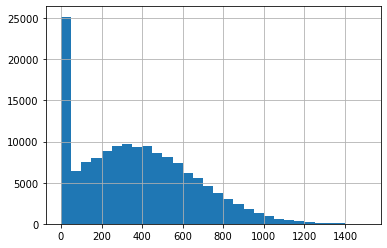

In [9]:
plt.hist(internet['mb_used'], bins=30, range=(0,1500))
plt.grid(True)
plt.show()  

Видим, что есть большой пик около нуля. 

In [10]:
internet[internet['mb_used'] == 0]['mb_used'].count()

19598

В таблице почти 20 тысяч строк, в которых количество использованных мегабайт равно нулю. Так как в таблице представлены данные об интернет-сессиях, можно предположить, что записи о новой интернет-сессии создаются автоматически - при включении пользователем интернета. А на деле может быть, что пользователь его никак не использовал - не открывал никакие сайты, не заходил в приложения, и вскоре выключал. Поскольку в дальнейшем мы будем работать не с данными по каждой сессии, а с суммой использованных мегабайт по месяцам, по пользователям, эти нули не скажутся на результатах исследования. 

На всякий случай, построим диаграмму размаха.

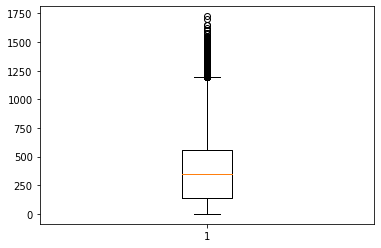

In [11]:
plt.boxplot(internet['mb_used']) ;

Как мы видим, нижняя граница "усов" совпадает с нулем. Значит, данные около нуля нельзя считать выбросами.

### Подсчет значений

В таблицы с данными о звонках, сообщениях и интернет-трафике добавим столбцы с месяцем.

In [12]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

Группируем каждую таблицу по пользователям и месяцам.

In [13]:
#рассчитываем кол-во звонков, совершенных каждым пользователем по месяцам и их общую продолжительность
calls_pivot = calls.pivot_table(index = ['user_id', 'month'], values = ['id', 'duration'], aggfunc = {'id':'count', 
                                                                                        'duration':'sum'}).reset_index()

#рассчитываем кол-во сообщений, отправленных каждым пользователем по месяцам
messages_pivot = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count').reset_index()

#рассчитываем объем интернет-трафика, израсходованного каждым пользователем по месяцам
internet_pivot = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum').reset_index()

In [14]:
display(calls_pivot.head())
display(messages_pivot.head())
display(internet_pivot.head())

,user_id,month,duration,id
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Объединим три созданные сводные таблицы и таблицу `users`.

In [15]:
data = calls_pivot.merge(messages_pivot, on = ['user_id', 'month'], how = 'outer')\
.merge(internet_pivot, on = ['user_id', 'month'], how = 'outer')\
.merge(users, on = 'user_id', how = 'left')

In [16]:
data.head(10)

,user_id,month,duration,id_x,id_y,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159.0,22.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172.0,43.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340.0,47.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408.0,52.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466.0,58.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000,10,350.0,57.0,73.0,14702.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000,11,338.0,43.0,58.0,14756.47,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000,12,333.0,46.0,70.0,9817.61,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1001,11,430.0,59.0,NaN,18429.34,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
9,1001,12,414.0,63.0,NaN,14036.66,41,NaT,Москва,Иван,Ежов,2018-11-01,smart


После слияния таблиц в некоторых столбцах появились пропуски. Если по какому-либо пользователю не было данных по одному из видов связи, логично предположить, что он его не использовал. Заполним эти пропуски нулями.

In [17]:
data['duration'] = data['duration'].fillna(value=0)
data['id_x'] = data['id_x'].fillna(value=0)
data['id_y'] = data['id_y'].fillna(value=0)
data['mb_used'] = data['mb_used'].fillna(value=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3214 non-null   int64         
 1   month       3214 non-null   int64         
 2   duration    3214 non-null   float64       
 3   id_x        3214 non-null   float64       
 4   id_y        3214 non-null   float64       
 5   mb_used     3214 non-null   float64       
 6   age         3214 non-null   int64         
 7   churn_date  187 non-null    datetime64[ns]
 8   city        3214 non-null   object        
 9   first_name  3214 non-null   object        
 10  last_name   3214 non-null   object        
 11  reg_date    3214 non-null   datetime64[ns]
 12  tariff      3214 non-null   object        
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 351.5+ KB


Необходимо округлить значения в столбце `mb_used` до гигабайт.

In [18]:
data['mb_used'] = np.ceil(data['mb_used'] / 1024).astype('int')

Переименуем некоторые столбцы в созданной таблице.

In [19]:
data = data.rename(columns = {'duration' : 'calls_duration', 'id_x' : 'calls_total', 'id_y' : 'messages_total', 
                              'mb_used' : 'gb_used'})

Так как мы присоединяли таблицу с пользователями способом `left`, два пользователя, по которым не была найдена информация в таблицах с информацией о звонках, сообщениях, интернете, оказались не включены в итоговую таблицу. То есть фактически они вообще не пользовались услугами тарифа и не принесли выручки. На дальнейших расчетах их отсутствие в таблице никак не отразится.

In [20]:
data.user_id.unique().shape 

(498,)

Напишем функцию для подсчета помесячной выручки с каждого пользователя.

In [21]:
#установим названия тарифов в качестве индексов
tariffs.set_index('tariff_name', inplace=True)

def month_profit(row): 

    tariff = row['tariff']
    tariff_row = tariffs.loc[tariff] 

#если лимит по тарифу не превышен, т.е. разница будет отрицательной, то переменная примет значение 0
    duration_above_limit = max(row['calls_duration'] - tariff_row['minutes_included'], 0)
    messages_above_limit = max(row['messages_total'] - tariff_row['messages_included'], 0)
    traffic_above_limit = max(row['gb_used'] - (tariff_row['mb_per_month_included'] / 1024), 0)

    return ((duration_above_limit * tariff_row['rub_per_minute']) + (messages_above_limit * tariff_row['rub_per_message']) +
            (traffic_above_limit * tariff_row['rub_per_gb'])) + tariff_row['rub_monthly_fee']

#создаем столбец со значениями-результатами работы функции
data['profit'] = data.apply(month_profit, axis=1)
data.head(10)

,user_id,month,calls_duration,calls_total,messages_total,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,profit
0,1000,5,159.0,22.0,22.0,3,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
1,1000,6,172.0,43.0,60.0,23,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
2,1000,7,340.0,47.0,75.0,14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
3,1000,8,408.0,52.0,81.0,14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
4,1000,9,466.0,58.0,57.0,15,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
5,1000,10,350.0,57.0,73.0,15,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
6,1000,11,338.0,43.0,58.0,15,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
7,1000,12,333.0,46.0,70.0,10,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
8,1001,11,430.0,59.0,0.0,18,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1150.0
9,1001,12,414.0,63.0,0.0,14,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,550.0


## Анализ данных

Создадим два среза в зависимости от тарифа.

In [22]:
smart_data = data.query('tariff == "smart"').reset_index(drop=True)
ultra_data = data.query('tariff == "ultra"').reset_index(drop=True)

Создадим сводную таблицу для тарифа smart, в которой будет среднее всех проговоренных минут, отправленных сообщений и потраченного интернет-трафика пользователями тарифа по месяцам. Затем найдем среднее, стандартное отклонение и дисперсию исследуемых значений.

In [23]:
smart_data_pivot = smart_data.pivot_table(index = ['month', 'tariff'], values = 
                ['calls_duration', 'messages_total', 'gb_used', 'user_id', 'profit'], aggfunc = {'calls_duration' : 'mean',
                'messages_total' : 'mean', 'gb_used' : 'mean', 'profit' : 'mean', 'user_id' : 'count'})
display(smart_data_pivot)
print('')
print('Минут разговора в среднем в месяц:', smart_data_pivot['calls_duration'].describe()['mean'])
print('Стандартное отклонение минут разговора:', smart_data_pivot['calls_duration'].describe()['std'])
print('Дисперсия минут разговора:', smart_data_pivot['calls_duration'].describe()['std'] ** 2)
print('')
print('Количество сообщений в среднем в месяц:', smart_data_pivot['messages_total'].describe()['mean'])
print('Стандартное отклонение количества сообщений:', smart_data_pivot['messages_total'].describe()['std'])
print('Дисперсия количества сообщений:', smart_data_pivot['messages_total'].describe()['std'] ** 2)
print('')
print('Гигабайт интернета в среднем в месяц:', smart_data_pivot['gb_used'].describe()['mean'])
print('Стандартное отклонение гигабайт интернета:', smart_data_pivot['gb_used'].describe()['std'])
print('Дисперсия гигабайт интернета:', smart_data_pivot['gb_used'].describe()['std'] ** 2)

,,calls_duration,gb_used,messages_total,profit,user_id
month,tariff,,,,,
1,smart,203.852941,8.735294,18.235294,721.323529,34
2,smart,298.689655,11.844828,24.086207,827.603448,58
3,smart,390.051948,15.233766,31.857143,1164.623377,77
4,smart,367.133929,13.625000,30.741071,963.089286,112
5,smart,387.361702,15.907801,33.773050,1197.510638,141
6,smart,395.640244,15.951220,33.402439,1204.018293,164
7,smart,408.353234,15.875622,33.751244,1223.950249,201
8,smart,421.468085,16.736170,33.638298,1320.595745,235
9,smart,428.611538,16.392308,33.638462,1249.946154,260



Минут разговора в среднем в месяц: 386.76049870568664
Стандартное отклонение минут разговора: 72.26200398840187
Дисперсия минут разговора: 5221.797220419808

Количество сообщений в среднем в месяц: 31.413210661085547
Стандартное отклонение количества сообщений: 5.103413278609601
Дисперсия количества сообщений: 26.044827092288795

Гигабайт интернета в среднем в месяц: 15.19872845502155
Стандартное отклонение гигабайт интернета: 2.6269725315358126
Дисперсия гигабайт интернета: 6.900984681443676


Проделаем все то же самое для тарифа ultra. Создадим сводную таблицу, в которой будет среднее всех проговоренных минут, отправленных сообщений и потраченного интернет-трафика пользователями тарифа по месяцам. Затем найдем среднее, стандартное отклонение и дисперсию исследуемых значений.

In [24]:
ultra_data_pivot = ultra_data.pivot_table(index = ['month', 'tariff'], values = 
                ['calls_duration', 'messages_total', 'gb_used', 'user_id', 'profit'], aggfunc = {'calls_duration' : 'mean',
                'messages_total' : 'mean', 'gb_used' : 'mean', 'profit' : 'mean', 'user_id' : 'count'})
display(ultra_data_pivot)
print('')
print('Минут разговора в среднем в месяц на всех пользователей:', ultra_data_pivot['calls_duration'].describe()['mean'])
print('Стандартное отклонение минут разговора:', ultra_data_pivot['calls_duration'].describe()['std'])
print('Дисперсия минут разговора:', ultra_data_pivot['calls_duration'].describe()['std'] ** 2)
print('')
print('Количество сообщений в среднем в месяц на всех пользователей:', ultra_data_pivot['messages_total'].describe()['mean'])
print('Стандартное отклонение количества сообщений:', ultra_data_pivot['messages_total'].describe()['std'])
print('Дисперсия количества сообщений:', ultra_data_pivot['messages_total'].describe()['std'] ** 2)
print('')
print('Гигабайт интернета в среднем в месяц на всех пользователей:', ultra_data_pivot['gb_used'].describe()['mean'])
print('Стандартное отклонение гигабайт интернета:', ultra_data_pivot['gb_used'].describe()['std'])
print('Дисперсия гигабайт интернета:', ultra_data_pivot['gb_used'].describe()['std'] ** 2)

,,calls_duration,gb_used,messages_total,profit,user_id
month,tariff,,,,,
1,ultra,428.111111,13.222222,33.777778,1950.000000,9
2,ultra,297.125000,12.000000,21.958333,1975.000000,24
3,ultra,489.648649,17.648649,32.297297,2014.864865,37
4,ultra,458.018182,16.963636,31.563636,2001.818182,55
5,ultra,510.328358,19.373134,37.850746,2059.701493,67
6,ultra,479.702381,18.940476,41.726190,2039.285714,84
7,ultra,545.791209,20.505495,49.846154,2118.131868,91
8,ultra,510.775701,19.598131,48.439252,2083.177570,107
9,ultra,539.443478,19.243478,52.286957,2024.347826,115



Минут разговора в среднем в месяц на всех пользователей: 495.9343101624627
Стандартное отклонение минут разговора: 77.45007182218454
Дисперсия минут разговора: 5998.513625261544

Количество сообщений в среднем в месяц на всех пользователей: 43.71498284147191
Стандартное отклонение количества сообщений: 12.320470269273553
Дисперсия количества сообщений: 151.79398765605353

Гигабайт интернета в среднем в месяц на всех пользователей: 18.25893661289434
Стандартное отклонение гигабайт интернета: 2.921532788081398
Дисперсия гигабайт интернета: 8.535353831834666


Построим график, показывающий распределение продолжительности звонков по месяцам и по тарифам.

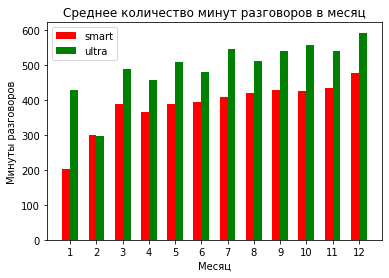

In [25]:
n=12
r = np.arange(n)
width = 0.3


xvals = smart_data_pivot['calls_duration']
bar1 = plt.bar(r, xvals, width, color = 'r')

yvals = ultra_data_pivot['calls_duration']
bar2 = plt.bar(r + width, yvals, width, color='g')

plt.xlabel('Месяц')
plt.ylabel('Минуты разговоров')
plt.title('Среднее количество минут разговоров в месяц')

plt.legend( (bar1, bar2), ('smart', 'ultra') )
plt.xticks(r + width/2,['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.show();

Как мы видим из графика, средняя продолжительность разговоров растет от месяца к месяцу по обоим тарифам. В какой-то степени это связано с ростом числа пользователей в целом. Количество минут, потраченных на разговоры, пользователями тарифа ultra в среднем больше, чем у пользователей тарифа smart, потому что по нему установлен более высокий лимит. Для пользователей обоих тарифов в среднем не характерно превышение лимитов, установленных на продолжительность звонков. 

Теперь построим график, показывающий распределение количества отправленных сообщений (смс) по месяцам и по тарифам.

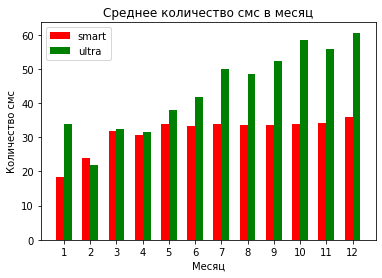

In [26]:
n=12
r = np.arange(n)
width = 0.3


xvals = smart_data_pivot['messages_total']
bar1 = plt.bar(r, xvals, width, color = 'r')

yvals = ultra_data_pivot['messages_total']
bar2 = plt.bar(r + width, yvals, width, color='g')

plt.xlabel('Месяц')
plt.ylabel('Количество смс')
plt.title('Среднее количество смс в месяц')

plt.legend( (bar1, bar2), ('smart', 'ultra') )
plt.xticks(r + width/2,['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.show();

Распределение почти аналогично предыдущему. В течение года наблюдается рост отправленных сообщений в месяц (в среднем). Пользователи тарифа ultra отправляют больше сообщений, но в среднем ни в одном, ни в другом тарифе не прослеживается превышение установленных лимитов.

Также построим график распределения среднего использованного объема интернет-трафика по месяцам и тарифам.

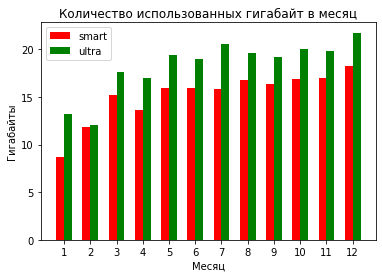

In [27]:
n=12
r = np.arange(n)
width = 0.3


xvals = smart_data_pivot['gb_used']
bar1 = plt.bar(r, xvals, width, color = 'r')

yvals = ultra_data_pivot['gb_used']
bar2 = plt.bar(r + width, yvals, width, color='g')

plt.xlabel('Месяц')
plt.ylabel('Гигабайты')
plt.title('Количество использованных гигабайт в месяц')

plt.legend( (bar1, bar2), ('smart', 'ultra') )
plt.xticks(r + width/2,['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.show();
  

Практически в каждом последующем месяце объем использованного трафика больше, чем в предыдущем. Это справедливо как для пользователей тарифа smart, так и для пользователей тарифа ultra. Пользователи тарифа smart в девяти месяцах из двенадцати в среднем использовали немного больше интернет-трафика, чем включено в их тариф. Пользователи тарифа ultra в среднем не превышали лимит.

Наконец, построим график распределения средней выручки по месяцам.

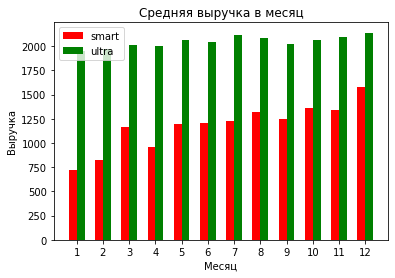

In [28]:
n=12
r = np.arange(n)
width = 0.3


xvals = smart_data_pivot['profit']
bar1 = plt.bar(r, xvals, width, color = 'r')

yvals = ultra_data_pivot['profit']
bar2 = plt.bar(r + width, yvals, width, color='g')

plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.title('Средняя выручка в месяц')

plt.legend( (bar1, bar2), ('smart', 'ultra') )
plt.xticks(r + width/2,['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.show();

Средняя выручка от тарифа ultra в каждом месяце значительно превосходит среднюю выручку от тарифа smart. Если смотреть на динамику средней выручки по месяцам - для тарифа ultra она +/- одинакова, по тарифу smart же наблюдается некоторый рост к концу года.

## Проверка гипотез

### Гипотеза о средней выручке пользователей тарифов «Ультра» и «Смарт»

Посчитаем количество пользователей каждого тарифа.

In [29]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Сформулируем нулевую гипотезу (H₀) — средняя выручка пользователей тарифов "Ультра" и "Смарт" равна.

Альтернативная гипотеза (H₁) — средняя выручка пользователей тарифов "Ультра" и "Смарт" различается.

Для проверки гипотез сравниваем среднее двух генеральных совокупностей методом `scipy.stats.ttest_ind (array1, array2, equal_var)`. Критический уровень статистической значимости зададим 5%.

In [30]:
alpha = 0.05

results = st.ttest_ind(smart_data['profit'], ultra_data['profit'], equal_var=False) #equal_var устанавливаем False,  
                                                                                    #потому что размеры выборок различаются
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


P-value сильно меньше порогового значения alpha, поэтому гипотеза H₀ отвергается. Значит, средняя выручка пользователей тарифов "Ультра" и "Смарт" различается.

In [31]:
display(data.groupby(['tariff'])['profit'].mean())

tariff
smart    1289.973531
ultra    2070.152284
Name: profit, dtype: float64

### Гипотеза о средней выручке пользователей из Москвы 

Сформулируем нулевую гипотезу (H₀) — средняя выручка пользователей из Москвы такая же как средняя выручка пользователей из регионов.

Альтернативная гипотеза (H₁) — средняя выручка пользователей из Москвы отличается от средней выручки пользователей из регионов.

Для проверки гипотез сравниваем среднее двух генеральных совокупностей методом `scipy.stats.ttest_ind (array1, array2, equal_var)`. Критический уровень статистической значимости зададим 5%.

In [32]:
#создаем две таблицы: с пользователями из Москвы и из регионов
moscow = data[data['city'] == 'Москва']
region = data[data['city'] != 'Москва']

alpha = 0.05

results = st.ttest_ind(moscow['profit'], region['profit'], equal_var=False) #equal_var устанавливаем False,  
                                                                            #потому что размеры выборок различаются
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно почти 52%. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.

In [33]:
print("Средняя выручка по Москве:", moscow['profit'].mean())
print("Средняя выручка по регионам:", region['profit'].mean())

Средняя выручка по Москве: 1546.7135842880523
Средняя выручка по регионам: 1524.9362274298885


## Вывод

Мы проверили две гипотезы:

1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Мы установили, что данные не противоречат первой гипотезе, средняя прибыль от пользователей разных тарифов различается. По результатам статистического анализа для оператора средний доход от тарифа «Ультра» составляет 2070 рублей, а от тарифа «Смарт» 1290 рублей. Это можно объяснить тем, что стоимость тарифа «Ультра» почти в три с половиной раза превышает стоимость тарифа «Смарт». Таким образом, для «Мегалайн» выгоднее тариф «Ультра», он приносит больше денег.

Что касается второй гипотезы, мы ее отвергли. Нет явной разницы между средними выручками пользователей из Москвы и из регионов.

**Дополнительные выводы**

Пользователей тарифа «Ультра» в два раза меньше, чем пользователей второго тарифа, что опять же можно объяснить его высокой стоимостью. Пользователи тарифа «Ультра» в среднем не расходуют весь предоставленный пакет минут, сообщений и гигабайт. А пользователям тарифа «Смарт» в среднем не хватает объема интернет-трафика.